In [6]:
#pip install yfinance
#pip install PyPortfolioOpt

### Preparing Libraries

In [7]:
import pandas as pd
import pandas_ta as ta
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import pypfopt
from pypfopt.expected_returns import mean_historical_return
from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from datetime import datetime

### Engine

To assess the portfolio effectiveness, rigorous back-testing occurred, refining the composition during the 2015-2022 training period and evaluating performance against real-world conditions from 2023 to the present. Two operational approaches were applied: the first integrated weights with stock returns, while the second determined the number of shares to purchase, adhering to a $1,000,000 portfolio.

In [27]:
def Engine(stock_list, variations = None):
    train_start_period = "2015-01-01"
    train_end_period = "2022-12-31"
    if variations:
        sector_mapper, sector_lower, sector_upper = variations
    df = pd.DataFrame()
    for company in stock_list:
        stock = yf.Ticker(company)
        hist = stock.history(start=train_start_period, end=train_end_period).Close
        df[company] = hist
    df = df.dropna()

    if variations:
        stock_weights, cleaned_weights = get_weights_variation(df,sector_mapper,sector_lower,sector_upper)
    else:
        stock_weights, cleaned_weights = get_weights(df)

    test_start_period = "2023-01-01"
    test_end_period = datetime.today().strftime('%Y-%m-%d')
    
    dftest = pd.DataFrame()
    for company in stock_list:
        stock = yf.Ticker(company)
        hist = stock.history(start=test_start_period, end=test_end_period).Close
        dftest[company] = hist
    dftest = dftest.dropna()
    
    daily_portfolio_valuetest = np.dot(dftest, stock_weights)

    df_log_returns = pd.DataFrame(data={'Portfolio Value': daily_portfolio_valuetest}, index=dftest.index)
    logreturns = np.log(df_log_returns/df_log_returns.shift(1))
    """
    -------------------------------OLD METHOD-----------------------------------
    log_returns = np.log(dftest/dftest.shift(1))
    log_returns_cov = log_returns.cov()
    
    print(cleaned_weights)
    weight_method(stock_weights,log_returns,log_returns_cov)
    """
    weight_ret, weight_vol, weight_sr, weight_cummu = weight_method(logreturns)

    share_ret, share_vol, share_sr, share_cummu = share_method(dftest, cleaned_weights)

    # round(annual_regular_ret.values[0], 3)

    return (
        [round(weight_ret.values[0],3), round(weight_vol.values[0],3), round(weight_sr.values[0],3), weight_cummu], 
        [round(share_ret.values[0],3), round(share_vol.values[0],3), round(share_sr.values[0],3), share_cummu]
        )

def calculate_returns(weights, returns):
    return np.sum(returns.mean() * weights) * 252

def calculate_volatility(weights, returns_covariance):
    cov_dot_weights = np.dot(returns_covariance * 252, weights)
    variance = np.dot(weights, cov_dot_weights)
    return np.sqrt(variance)

def get_weights(df):
    mu = mean_historical_return(df)
    S = CovarianceShrinkage(df).ledoit_wolf()

    ef = EfficientFrontier(mu, S)

    weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()

    # ef.portfolio_performance(verbose=True)
    ef.portfolio_performance(verbose=False)

    stock_weights = list(cleaned_weights.values())
    
    return stock_weights, cleaned_weights

def get_weights_variation(df,sector_mapper,sector_lower,sector_upper):
    mu = mean_historical_return(df)
    S = CovarianceShrinkage(df).ledoit_wolf()

    ef = EfficientFrontier(mu, S)

    ef.add_sector_constraints(sector_mapper, sector_lower=sector_lower, sector_upper=sector_upper)

    weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()

    ef.portfolio_performance(verbose=True)

    stock_weights = list(cleaned_weights.values())
    
    return stock_weights, cleaned_weights
"""
----------------------------- OLD METHOD----------------------------------------
def weight_method(stock_weights,log_returns,log_returns_cov):
    risk_free_rate = 0

    # Calculate the expected portfolio return
    log_portfolio_return = calculate_returns(stock_weights, log_returns)
    portfolio_return = np.exp(log_portfolio_return)-1

    # Calculate the portfolio volatility
    log_portfolio_volatility = calculate_volatility(stock_weights, log_returns_cov)
    portfolio_volatility = np.exp(log_portfolio_volatility) - 1

    # Calculate the Sharpe ratio
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility

    print("----------------------Weight method----------------------")
    print("Portfolio Return:", portfolio_return)
    print("Portfolio Volatility:", portfolio_volatility)
    print("Sharpe Ratio:", sharpe_ratio)
"""
def weight_method(log_returns):
    risk_free_rate = 0
    
    # Calculate the expected portfolio return
    log_portfolio_return = log_returns.mean() * 252
    portfolio_return = np.exp(log_portfolio_return)-1

    # Calculate the portfolio volatility
    log_portfolio_volatility = (np.exp(log_returns)-1).std()
    portfolio_volatility = log_portfolio_volatility * (252 ** 0.5)

    # Calculate the Sharpe ratio
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility

    # Cumulative returns
    weight_cumulative_returns = (1 + log_returns[1:]).cumprod()

    # print("----------------------Weight method----------------------")
    # print("Portfolio Return:", portfolio_return)
    # print("Portfolio Volatility:", portfolio_volatility)
    # print("Sharpe Ratio:", sharpe_ratio)

    return [portfolio_return, portfolio_volatility, sharpe_ratio, weight_cumulative_returns]

def share_method(df,cleaned_weights):

    risk_free_rate = 0
    portfolio_value = 1000000

    # Calculate the number of shares to purchase using DiscreteAllocation
    #latest_prices = get_latest_prices(df)
    earliest_prices = df.iloc[0]

    da = DiscreteAllocation(cleaned_weights, earliest_prices, total_portfolio_value=portfolio_value)
    #allocation, leftover = da.lp_portfolio(solver="CBC")
    allocation, leftover = da.greedy_portfolio()

    all_tickers = df.columns
    quantity_to_buy = [allocation.get(ticker, 0) for ticker in all_tickers]

    # Calculate the daily portfolio value
    daily_portfolio_value = np.dot(df, quantity_to_buy)
    daily_portfolio_value += leftover
    df_portfolio_value = pd.DataFrame(data={'Portfolio Value': daily_portfolio_value}, index=df.index)
    portfolio_log_returns = np.log(df_portfolio_value/df_portfolio_value.shift(1))
    
    # Annual Returns
    portfolio_annual_returns = portfolio_log_returns.mean() * 252
    annual_regular_ret = np.exp(portfolio_annual_returns)-1

    # Standard Deviation
    daily_portfolio_sd = (np.exp(portfolio_log_returns)-1).std()
    annual_std =  daily_portfolio_sd * (252 **0.5)

    # Sharpe Ratio
    sharpe_ratio_discrete = (annual_regular_ret - risk_free_rate) / annual_std

    # Cumulative returns
    share_cumulative_returns = (1 + portfolio_log_returns[1:]).cumprod()

    # print("----------------------Share method----------------------")
    # print("Total Portfolio Return with Discrete Allocation:", annual_regular_ret)
    # print("Portfolio Volatility with Discrete Allocation:", annual_std)
    # print("Sharpe Ratio with Discrete Allocation:", sharpe_ratio_discrete)

    return [annual_regular_ret, annual_std, sharpe_ratio_discrete, share_cumulative_returns]


### Stock Selection

15 stocks were chosen from SGX based on trade volume in 2023. The top 15 companies with the highest trade volume were selected.

In [9]:
# Stock Selection

#2015 STOCK SELECTION: Singtel, DBS, SGX, Capitaland, SATS, Singapore Post, SIA, Starhub, ST eng, Keppel coporation, Sembcorp, yoma, ocbc, city developments
stock_list = ["Z74.SI","D05.SI","S68.SI","C38U.SI","S58.SI","S08.SI","C6L.SI","CC3.SI","S63.SI","BN4.SI","S51.SI","Z59.SI","O39.SI","C09.SI","F99.SI"]

"""
#2023 STOCK SELECTION: DBS, UOB OCBC, SINGTEL, CapLand Intcom, YZJ Shipbldg, Sembcorp, Genting, Keppel Corp, CapLand Ascendas, Capitaland Invest, MapleTree Log, Wilmar Intl, SIA, MapleTree PanAsia Com Tr
stock_list = ["D05.SI","U11.SI","O39.SI","Z74.SI","C38U.SI","BS6.SI","S51.SI","G13.SI","BN4.SI","A17U.SI","9CI.SI","M44U.SI","F34.SI","C6L.SI","N2IU.SI"]
"""

'\n#2023 STOCK SELECTION: DBS, UOB OCBC, SINGTEL, CapLand Intcom, YZJ Shipbldg, Sembcorp, Genting, Keppel Corp, CapLand Ascendas, Capitaland Invest, MapleTree Log, Wilmar Intl, SIA, MapleTree PanAsia Com Tr\nstock_list = ["D05.SI","U11.SI","O39.SI","Z74.SI","C38U.SI","BS6.SI","S51.SI","G13.SI","BN4.SI","A17U.SI","9CI.SI","M44U.SI","F34.SI","C6L.SI","N2IU.SI"]\n'

### Variations

In [10]:
sector_mapper_1 = {
    "Z74.SI": "Communication",
    "D05.SI": "Finance",
    "S68.SI": "Finance",
    "C38U.SI": "Real Estate",
    "S58.SI": "Industrials",
    "S08.SI": "Industrials",
    "C6L.SI": "Industrials",
    "CC3.SI": "Communication",
    "S63.SI": "Industrials",
    "BN4.SI": "Industrials",
    "S51.SI": "Industrials",
    "Z59.SI": "Industrials",
    "O39.SI": "Finance",
    "C09.SI": "Real Estate",
    "F99.SI": "Consumer Defensive"
}
sector_lower_1 = {"Industrials": 0.1, "Communication": 0.1, "Real Estate": 0.05} 
sector_upper_1 = {
    "Consumer Defensive": 0.3,
    "Finance": 0.5
}
variations = []
var1 = [sector_mapper_1, sector_lower_1, sector_upper_1]
variations.append(var1)

sector_mapper_2 = {
    "Z74.SI": "Communication",
    "D05.SI": "Finance",
    "S68.SI": "Finance",
    "C38U.SI": "Real Estate",
    "S58.SI": "Industrials",
    "S08.SI": "Industrials",
    "C6L.SI": "Industrials",
    "CC3.SI": "Communication",
    "S63.SI": "Industrials",
    "BN4.SI": "Industrials",
    "S51.SI": "Industrials",
    "Z59.SI": "Industrials",
    "O39.SI": "Finance",
    "C09.SI": "Real Estate",
    "F99.SI": "Consumer Defensive"
}
sector_lower_2 = {"Industrials": 0.1, "Communication": 0.1, "Real Estate": 0.1} 
sector_upper_2 = {
    "Consumer Defensive": 0.2,
    "Finance": 0.5
}
var2 = [sector_mapper_2, sector_lower_2, sector_upper_2]
variations.append(var2)


In [11]:
sector_mapper_1 = {
    "D05.SI": "Finance",
    "U11.SI": "Finance",
    "O39.SI": "Finance",
    "Z74.SI": "Communication",
    "C38U.SI": "Real Estate",
    "BS6.SI": "Industrials",
    "S51.SI": "Industrials",
    "G13.SI": "Consumer Cyclical",
    "BN4.SI": "Industrials",
    "A17U.SI": "Real Estate",
    "9CI.SI": "Real Estate",
    "M44U.SI": "Real Estate",
    "F34.SI": "Consumer Defensive",
    "C6L.SI": "Industrials",
    "N2IU.SI": "Real Estate"
}
sector_lower_1 = {"Industrials": 1/6, "Communication": 1/6, "Real Estate": 1/6, "Consumer Cyclical": 1/6, "Consumer Defensive": 1/6, "Finance": 1/6}

sector_mapper_2 = {
    "D05.SI": "Finance",
    "U11.SI": "Finance",
    "O39.SI": "Finance",
    "Z74.SI": "Communication",
    "C38U.SI": "Real Estate",
    "BS6.SI": "Industrials",
    "S51.SI": "Industrials",
    "G13.SI": "Consumer Cyclical",
    "BN4.SI": "Industrials",
    "A17U.SI": "Real Estate",
    "9CI.SI": "Real Estate",
    "M44U.SI": "Real Estate",
    "F34.SI": "Consumer Defensive",
    "C6L.SI": "Industrials",
    "N2IU.SI": "Real Estate"
}
sector_lower_2 = {}
sector_upper_2 = {}

sector_mapper_3 = {
    "D05.SI": "Finance",
    "U11.SI": "Finance",
    "O39.SI": "Finance",
    "Z74.SI": "Communication",
    "C38U.SI": "Real Estate",
    "BS6.SI": "Industrials",
    "S51.SI": "Industrials",
    "G13.SI": "Consumer Cyclical",
    "BN4.SI": "Industrials",
    "A17U.SI": "Real Estate",
    "9CI.SI": "Real Estate",
    "M44U.SI": "Real Estate",
    "F34.SI": "Consumer Defensive",
    "C6L.SI": "Industrials",
    "N2IU.SI": "Real Estate"
}
sector_lower_3 = {}
sector_upper_3 = {}

### Base Results

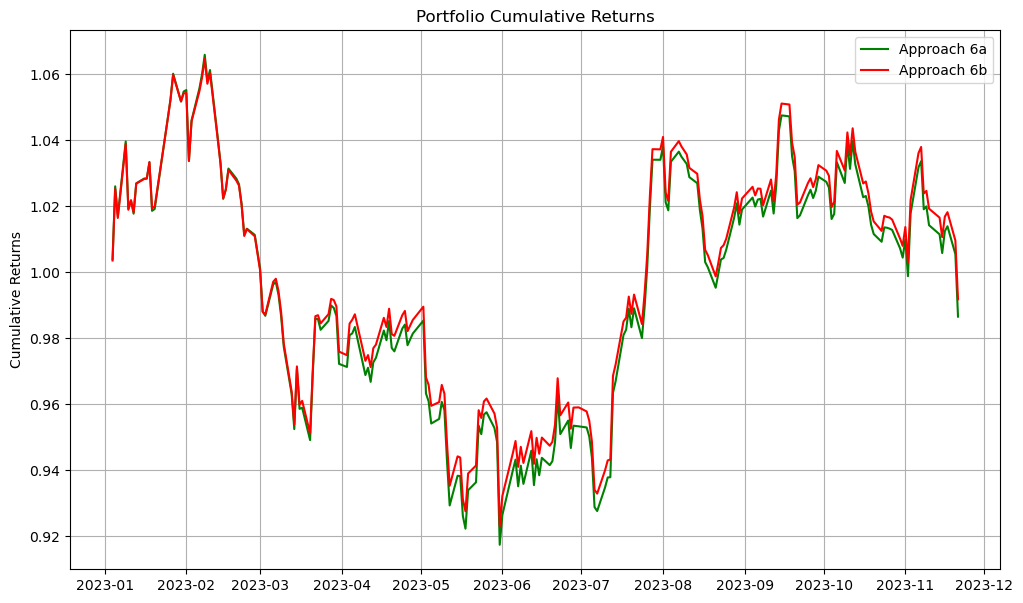

,Approach,Annualised Portfolio Returns (%),Portfolio Volatility (%),Portfolio Sharpe Ratio
0,6a,-0.5,14.5,-0.035
1,6b,0.0,14.1,0.003


In [35]:
import warnings
# Ignore FutureWarnings related to the append method in pandas
warnings.simplefilter(action='ignore', category=FutureWarning)

#Comparing performance between the 2 different approaches
weight_results, share_results = Engine(stock_list)

columns = ['Approach', 'Annualised Portfolio Returns (%)', 'Portfolio Volatility (%)', 'Portfolio Sharpe Ratio']
comparison_df = pd.DataFrame(columns=columns)

approach_6a_row = pd.Series({'Approach': '6a', 'Annualised Portfolio Returns (%)': weight_results[0]*100, 'Portfolio Volatility (%)': weight_results[1]*100, 'Portfolio Sharpe Ratio': weight_results[2]})
approach_6b_row = pd.Series({'Approach': '6b', 'Annualised Portfolio Returns (%)': share_results[0]*100, 'Portfolio Volatility (%)': share_results[1]*100, 'Portfolio Sharpe Ratio': share_results[2]})

comparison_df = comparison_df.append(approach_6a_row, ignore_index=True)
comparison_df = comparison_df.append(approach_6b_row, ignore_index=True)

#Plotting the returns between the 2 approaches
plt.figure(figsize=(12, 7))
plt.plot(weight_results[3], label='Approach 6a', color='green')
plt.plot(share_results[3], label='Approach 6b', color='red')
plt.title('Portfolio Cumulative Returns')
plt.ylabel('Cumulative Returns')
plt.legend()
plt.grid(True)
plt.show()

comparison_df

### Train Results

In [ ]:
for i in range(len(variations)):
    print("Variation " + str(i + 1))
    Engine(stock_list, variations[i])
    print("\n")

Variation 1
Expected annual return: 7.4%
Annual volatility: 15.6%
Sharpe Ratio: 0.35
----------------------Weight method----------------------
----------------------Share method----------------------


Variation 2
Expected annual return: 7.4%
Annual volatility: 15.6%
Sharpe Ratio: 0.35
----------------------Weight method----------------------
----------------------Share method----------------------


